In [153]:
import numpy as np
from scipy.integrate import quad
from scipy import constants
import matplotlib.pyplot as plt
%matplotlib inline  

pc_to_cm = 3.085677581e18 # cm

Rjupiter = 6.9911e9 # cm
AU = 1.495978707e13 # cm

In [100]:
# cgs unit
from scipy import constants
CC = constants.c*1e2
HH = constants.h*1e7
KK = constants.k*1e7
GG = constants.g*1e2
RR = constants.R*1e7
NA = constants.N_A
SIGMA = constants.sigma*1e3
AMU = 1.661e-24

In [101]:
def planck(wl, *args):
    """
    Returns the Planck function evaluated at wavelength wl and temperature temp.
    """
    wl = np.array(wl)
    temp, = args
    fac = HH * CC / (wl * KK * temp)
    return (2.0 * HH * CC**2 / (wl**5)) * (1. / (np.exp(fac) - 1.))

In [102]:
def planck_dIdnu(nu, *args):
    """
    Returns the Planck function evaluated at wavelength wl and temperature temp.
    """
    nu = np.array(nu)
    temp, = args
    fac = HH * nu / (KK * temp)
    return (2.0 * HH * nu**3 / (CC**2)) * (1. / (np.exp(fac) - 1.))

In [103]:
def planck_photon(wl, *args):
    """
    Returns the thermal intensity of photons at wavelength wl and temperature temp.
    """
    wl = np.array(wl)
    energy_intensity = planck(wl, *args)
    energy_per_photon = HH * CC / wl
    return energy_intensity / energy_per_photon

In [104]:
wls = [1.e-6, 2.e-6]
temp = 300.
print planck(wls, temp)
print planck_photon(wls, temp)

[ 0.  0.]
[ 0.  0.]


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: RuntimeWarning: overflow encountered in exp


In [105]:
# check with Solar Constant
Rsun_to_AU = 0.0046
print quad(planck, 0.01e-4, 5.0e-4, args=(5800.0,))[0]*Rsun_to_AU**2*np.pi


print quad(planck_dIdnu, 3e13, 3e+18, args=(5800.0,))[0]*Rsun_to_AU**2*np.pi

1350778.498
1356840.56849


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: RuntimeWarning: overflow encountered in exp


In [155]:
# mass, orbitMj = 1.0
Mp = 10*Mj
orbit = 5.0 # AU

# accretion temperature
Tacc=1e5*(Mp/Mj) # K

# accretion luminosity
Luminosity = 1e25*(Mp/Mj)**3 # erg/sec

# "class B" recombination rate
beta = 2.74e-14*(Mp/Mj)**(-3.0/4.0) # cm^3 / sec

In [107]:
planck_integrated = quad(planck, 0, 1.0e-4, args=(Tacc))[0]*np.pi
print planck_integrated

5.67037176037e+19


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: RuntimeWarning: overflow encountered in exp


In [108]:
# denoting that surface area by "surface", 
###  surface * planck_integrated = Luminosity
###  surface =  Luminosity  / planck_integrated 

surface = Luminosity  / planck_integrated 
print surface

176355280.087


In [109]:
Luminosity / ( SIGMA*Tacc**4 )

176355241.53349352

In [110]:
# Suppose photons with energy > 13.6 eV can ionize hydrogen

eV_to_Joule = 1.6e-19
eV_to_erg = eV_to_Joule * 1e7
wl_ionize = HH * CC / (13.6 * eV_to_erg )
print wl_ionize*1e7, "[nm]"

91.2888641208 [nm]


In [111]:
# photons per second

source = surface * np.pi * quad(planck_photon, 0, wl_ionize, args=(Tacc))[0]
print source, "[s^-1]"

2.66827340875e+37 [s^-1]


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: RuntimeWarning: overflow encountered in exp


In [112]:
energy_per_photon = Tacc * KK
ndot_photons = Luminosity / energy_per_photon
print ndot_photons

7.24297156525e+37


In [113]:
# DSS COMMENT: I recommend not using "magic numbers"
# https://en.wikipedia.org/wiki/Magic_number_(programming)#Unnamed_numerical_constants
# I assume the 5.0 is AU?  I don't know what the 1e3 or the 1.8e6 are, though.
# It would be easier to follow the code if you replace all magic numbers with named constants.
# You can use some judgment here, like the "**(-2)" exponent doesn't need to be named,
# but I would name nearly everything else -- even obvious things like 13.6, which could be
# named "Rydberg" or something similar.


# YF temporary comment
# "1.8e6" comes from equation (18) of the manuscript 
density = 1.8e6 * (orbit / 5.0 )**(-2) # [cm^{-3}]

In [114]:
# DSS COMMENT: Isn't the calculation up to here in MKS, not cgs?  Do we want AU_to_m instead?
# Not sure about this one....
AU_to_cm = 1.49597870700e13
stromgren = 3.0 / ( 4.0 * np.pi ) * ( source / ( density**2 * beta ) )**(1.0/3.0) / AU_to_cm
print stromgren, "[AU]"

0.190092170859 [AU]


In [115]:
Mjupiter_to_AU = Mjupiter / AU
print Mjupiter_to_AU

0.000467326170305


In [116]:
stromgren / Mjupiter_to_AU

406.7655161158778

In [117]:
erg_s_cm_Hz_to_Jy = 1e23
surface * planck_dIdnu(1e9, 1e6) / ( 4. * np.pi * (100.0*pc_to_cm )**2 ) * erg_s_cm_Hz_to_Jy 


4.5284472304198582e-24

In [118]:
# from http://ned.ipac.caltech.edu/level5/Madau6/Madau1_2.html eq. (4)

Rydberg_eV = 13.6 # eV
Rydberg_erg = Rydberg_eV * eV_to_erg # erg
sigma_L = 6.3e-18 # in cm^2
sigma_H = sigma_L * (energy_per_photon / Rydberg_erg)**(-3.)
print sigma_H
mfp = 1. / (density * sigma_H) # mean free path
print 'Mean Free Path: %1.3f AU' % (mfp / AU)
print 'Mean Free Path: %1.3f Rjup' % (mfp / Rjupiter)

2.46642300904e-20
Mean Free Path: 1.506 AU
Mean Free Path: 3221.918 Rjup


# Considering the balance between inoization rate and recombination rate

http://ned.ipac.caltech.edu/level5/Madau6/Madau1_2.html


- $\alpha $ : ionization fraction
- $E_{\rm photon}$ : photon energy
- $T _e$ : electron temperature
- $\beta [T_e] $ : recombination rate $=2.6 \times 10^{-13} [{\rm cm^3/sec}]\cdot\left(\frac{T_e}{10^{4}} \right)^{-3/4}$
- $ \sigma _H [E_{\rm photon}] $ : cross section for X-ray, $= 6.3 \times 10^{-18} [{\rm cm}^2] \cdot \left( \frac{E_{\rm photon}}{E_{\rm Rydberg}} \right)^{-3} $

Assuming an equlibrium state (?),

$ \frac{S}{ 4 \pi r^2 } n ( 1-\alpha ) \sigma _H [E_{\rm photon}] = n^2 \alpha^2 \beta [T_e]  $

$\Rightarrow  \left( \frac{4 \pi r^2 n \beta [T_e] }{S \sigma_H[E_{\rm photon}]} \right) \alpha ^2 + \alpha - 1 = 0 $




In [197]:
orbit = 5.
Tacc=1e6
Luminosity=1e28
energy_per_photon = Tacc * KK
ndot_photon =  Luminosity / energy_per_photon
print "energy_per_photon:", energy_per_photon
print "ndot_photon:", ndot_photon

# YF temporary comment
# "1.8e6" comes from equation (18) of the manuscript 
density = 1.8e6 * (orbit / 5.0 )**(-2) # [cm^{-3}]

energy_per_photon: 1.3806488e-10
ndot_photon: 7.24297156525e+37


In [199]:
Rydberg_eV = 13.6 # eV
Rydberg_erg = Rydberg_eV * eV_to_erg # erg
print Rydberg_erg
sigma_L = 6.3e-18 # in cm^2
sigma_H = sigma_L * (energy_per_photon / Rydberg_erg)**(-3.)
print sigma_H

2.176e-11
2.46642300904e-20


In [200]:
T_e = 1e4
beta = 2.6e-13 * (T_e/1e4)**(-3./4.)

In [201]:
def ionization_fraction(radius):
    a = density*beta*4.*np.pi*radius**2/ndot_photon/sigma_H
    b = 1.
    c = -1.
    numerator = -1.*b + np.sqrt( b**2 - 4.*a*c )
    denominator = 2.*a
    return numerator/denominator

In [202]:
r_tics = np.linspace(1, 500, 500)
y_tics = ionization_fraction(r_tics*Rjupiter)

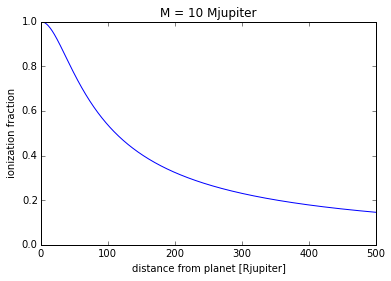

In [203]:
plt.plot(r_tics, y_tics)
plt.title('M = 10 Mjupiter')
plt.xlabel("distance from planet [Rjupiter]")
plt.ylabel("ionization fraction")
plt.ylim(0,1)
plt.show()